In [1]:
### setting the different directories 

# on the server (linux):
# where to find the images:
home_dir = '/home/rick/Documents/HannahZ'
# folder where to save code and so on
code_dir = home_dir + '/Code'
# where to save the final models
model_dir = code_dir + '/Final_models'
# where to save the logs for visualization in TensorBoard
log_dir = code_dir + '/logs'
# where to save the weights
new_weight_dir = code_dir + '/new_weights'

# # on my computer (windows):
# # where to find the images:
# home_dir = '\\Users\\ThinkPad User\\Google Drive\\DeepSolaris'
# # folder where to save code and so on
# code_dir = '\\Users\\ThinkPad User\\Google Drive\\Master_thesis_H_Z_DL&NN\\Results\\'
# # where to save the final models
# model_dir = 'E:\\FinalModels\\'
# # where to save the logs for visualization in TensorBoard
# log_dir = code_dir + '\\logs'


import os
os.chdir(home_dir)

In [19]:
### Loading the relevant packages

from keras import backend as K
from keras.models import Model
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.engine import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape 

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy
from keras import backend as K
from sklearn.model_selection import train_test_split

from random import randrange
from random import seed
from random import sample

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta
import math
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import keras
from keras.callbacks import Callback
seed(0)

In [7]:
### Loading the images from California (over 30.000 just for training)

os.chdir(home_dir)
train_images = np.load('train_images_Bradbury.npy')
# valid_images = np.load('validation_images_AcMüDüHo.npy')
Btest_images = np.load('test_images_Bradbury.npy')
train_labels = np.load('train_labels_Bradbury.npy')
# valid_labels = np.load('validation_labels_AcMüDüHo.npy')
Btest_labels = np.load('test_labels_Bradbury.npy')

# creating a validation set out of the data
Btrain_images, Bvalid_images, Btrain_labels, Bvalid_labels = train_test_split(train_images, train_labels, 
                                                                            test_size = 0.1, random_state = 0)

print("Size of:")
print("- Training-set:\t\t{}".format(len(Btrain_labels)))
print("- Validation-set:\t{}".format(len(Bvalid_labels)))
print("- Test-set:\t\t{}".format(len(Btest_labels)))

Size of:
- Training-set:		28598
- Validation-set:	3178
- Test-set:		7946


In [8]:
### Loading the images from NRW I used for my thesis

os.chdir(home_dir)
Atrain_images = np.load('training_images_AcMüDüHo.npy')
Avalid_images = np.load('validation_images_AcMüDüHo.npy')
Atest_images = np.load('test_images_AcMüDüHo.npy')
Atrain_labels = np.load('training_labels_AcMüDüHo.npy')
Avalid_labels = np.load('validation_labels_AcMüDüHo.npy')
Atest_labels = np.load('test_labels_AcMüDüHo.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(Atrain_labels)))
print("- Validation-set:\t{}".format(len(Avalid_labels)))
print("- Test-set:\t\t{}".format(len(Atest_labels)))

Size of:
- Training-set:		3357
- Validation-set:	374
- Test-set:		934


In [9]:
### Combining both data sets
test_images = np.concatenate((Btest_images, Atest_images), axis = 0)
test_labels = np.concatenate((Btest_labels, Atest_labels))
train_images = np.concatenate((Btrain_images, Atrain_images), axis = 0)
train_labels = np.concatenate((Btrain_labels, Atrain_labels))
valid_images = np.concatenate((Bvalid_images, Avalid_images), axis = 0)
valid_labels = np.concatenate((Bvalid_labels, Avalid_labels))

In [10]:
### Helper metrics functions

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall   
def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score
def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

no_of_epochs = 0

In [12]:
# choose training specifications (None or 'imagenet')
weights = 'imagenet'
# importing the currently used model
os.chdir(code_dir)
Model_base = keras.applications.xception.Xception(weights = weights, include_top=False)
# find out how many layers exist to find right number of trainable layers
len(Model_base.layers)

132

In [13]:
trainable_layers = 'All'
def compileModel(trainable_layers = 'Frozen'):
    global Final_model
    x = Model_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    Final_model = Model(inputs=Model_base.input, outputs=preds)
    if (trainable_layers == 'Frozen'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = False
    elif (trainable_layers == 'All'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = True
    else:
        for layer in Model_base.layers[:trainable_layers]:
            layer.trainable = False
        for layer in Model_base.layers[trainable_layers:]:  
            layer.trainable = True
    Final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy', precision, recall, fmeasure])

In [16]:
## take hyperparameters from previous experiments and only chose learning rates again
batch_size = 64
step_size = 315
mode = 'triangular'
base_lr = 0.000001
max_lr = 0.0003
epochs = 96

In [17]:
def train_Model(verbose =1, times = 2, epochs = 5, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False):
    start_time = time()   
    global h
    global no_of_epochs
    global name
    date = str(datetime.now().date())
    # logdir in linux:
    logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + '_base-' 
              + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    # logdir in windows:
    ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
    #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
            + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + ', *' + str(times))
    print(' - Model specifics:\t{}'.format(name))
    clr = CyclicLR(base_lr = base_lr, max_lr=max_lr,
                        step_size= stepsize, mode = mode)
    tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                         write_graph=False, write_images=False)
    if (use_tensorboard == True):
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [tbCallBack, clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
    else:
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
    no_of_epochs = no_of_epochs + epochs
    h = []
    h = clr.history
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [21]:
os.chdir(code_dir)

from CyclicLR import CyclicLR

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-06, max-lr 0.0003, *2
Time usage: 0:00:38 minutes


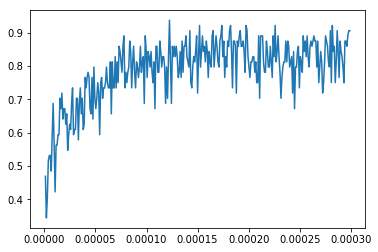

In [22]:
compileModel()
train_Model(epochs = 1, use_tensorboard = True, verbose = 0)
%matplotlib inline
lr = h['lr'][:step_size]
acc = h['acc'][:step_size]
plt.plot(lr, acc)

In [26]:
base_lr = 0.000001
max_lr = 0.0015

In [25]:
modelname = 'Xception'

In [28]:
def trainModels(batch_size = batch_size, stepsize = step_size, mode = mode, max_lr = max_lr, base_lr = base_lr, 
                epochs = epochs, verbose = 0):
    start_time = time()   
    global name
    global filepath
    global d    
    date = str(datetime.now().date())
    d = {}
    for i in range(5):
        compileModel()
        # logdir in linux:
        logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) 
                  + '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        # logdir in windows:
        ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
        #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
                + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + '_' + str(i))
        print(' - Model specifics:\t{}'.format(name))
        clr = CyclicLR(base_lr = base_lr, max_lr=max_lr, step_size= stepsize, mode = mode)
        fp = (str(modelname) + '_bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' 
              + str(base_lr) + '_mlr-' + str(max_lr) + '_e-' + str(epochs) + '_' + weights + '_' 
              + str(trainable_layers) + '_' + str(i))
        filepath = new_weight_dir + '/' + fp + '-{epoch:02d}-' +'.hdf5'
        checkp = ModelCheckpoint(filepath, monitor='val_acc', verbose= verbose, save_weights_only=True, 
                                save_best_only=True, mode='max', period=1)
        tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                             write_graph=False, write_images=False)
        d["FinalModel{0}".format(i)]= Final_model
        d["FinalModel{0}".format(i)].fit(x = train_images, y = train_labels, epochs = epochs, 
                                         callbacks= [tbCallBack, clr, checkp], batch_size = batch_size,
                                         validation_data = (valid_images, valid_labels), verbose = 0)
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [30]:
# train five times the model and only save the best weights
# usual time: 15 minutes - 18
fm = ['FinalModel1', 'FinalModel2', 'FinalModel3', 'FinalModel4', 'FinalModel5']
metrics = ['loss', 'acc', 'precision', 'recall']
name = ('bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' + str(base_lr) + '_mlr-' 
       + str(max_lr)) + '_' + str(weights) + '_' + str(trainable_layers)
trainModels(base_lr = base_lr, max_lr= max_lr, epochs = 24, verbose = 0,
           batch_size = batch_size, stepsize = step_size, mode = mode)

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-06, max-lr 0.0015_0
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-06, max-lr 0.0015_1
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-06, max-lr 0.0015_2
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-06, max-lr 0.0015_3


KeyboardInterrupt: 

In [32]:
# find out where 'bs' starts and '_' ends...
i = 0
last = 118
print(str(filepath)[46:last] + str(i) + str(filepath)[(last+1):])
filename = str(filepath)[46:last] + str(i)
print(filename)
from collections import OrderedDict

Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_0-{epoch:02d}-.hdf5
Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_0


In [40]:
# load the models again with their best weights and calculate evauation metrics
# usual time: 2 minutes
startTime = time()
FinalModelList = OrderedDict()
d3 = OrderedDict()
for i in range(3):
    filename = str(filepath)[46:last] + str(i) #+ str(filepath)[113:]
    weightlist = os.listdir(new_weight_dir)
    print(filename)
    best_filename = 'no'
    for el in weightlist:
        if(str(el)[:len(filename)]) == filename:
            if len(el)>(len(filename)+5):
                best_filename = el
    print(best_filename)
    best = str(best_filename)[-8:-6]
    os.chdir(new_weight_dir)
    compileModel()
    Final_model.load_weights(best_filename)
    FinalModelList["FinalModel{}-e{}".format(i,best)]= Final_model
    test_m = Final_model.evaluate(test_images, test_labels, verbose = 0)
    test_m = [round(el, 4) for el in test_m]
    valid_m = Final_model.evaluate(valid_images, valid_labels, verbose = 0)
    valid_m = [round(el, 4) for el in valid_m]
    train_m = Final_model.evaluate(train_images, train_labels, verbose = 0)
    train_m = [round(el, 4) for el in train_m]
    col = ["FinalModel{}-e{}".format(i,best)]
    print("td{}-e{}".format(i, best))
    d3["td{}-e{}".format(i, best)]= pd.DataFrame(data = test_m[:4], columns = col, index = metrics)
#     print('Best test accuracy model {}: {}'.format(i, test_m[1]))
#     print('Best validation accuracy model {}: {}'.format(i, valid_m[1]))
#     print('Best training accuracy model {}: {}'.format(i, train_m[1]))
    print('')
endTime = time()
finalTime = endTime - startTime
print('Time usage: ' + str(timedelta(seconds=int(round(finalTime)))) + ' minutes')

Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_0
Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_0-02-.hdf5
td0-e02

Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_1
Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_1-12-.hdf5
td1-e12

Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_2
Xception_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0015_e-24_imagenet_All_2-03-.hdf5
td2-e03

Time usage: 0:03:15 minutes


In [41]:
keys = d3.keys()
keys

['td0-e02', 'td1-e12', 'td2-e03']

In [42]:
FinalResults = pd.concat([d3[keys[0]], d3[keys[1]], d3[keys[2]]], axis=1)
FinalResults = pd.DataFrame(data = FinalResults.transpose(), columns = metrics)
FinalResults.sort_values(by = ['acc'], ascending = False)

,loss,acc,precision,recall
FinalModel2-e03,0.5145,0.8081,0.7430,0.9459
FinalModel0-e02,0.7129,0.7349,0.6573,0.9861
FinalModel1-e12,0.9521,0.7242,0.6545,0.9609


In [44]:
FinalModelList.keys()

['FinalModel0-e02', 'FinalModel1-e12', 'FinalModel2-e03']

In [45]:
i = 2
FinalModel = FinalModelList['FinalModel2-e03']

In [52]:
### checking the results of the retraining

print('for California:')
print('train_metrics') 
BtrainingRes = FinalModel.evaluate(Btrain_images, Btrain_labels)
for i, j in zip(metrics,BtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
BtestingRes = FinalModel.evaluate(Btest_images, Btest_labels)
for i, j in zip(metrics,BtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')

print('for NRW:')
print('train_metrics') 
AtrainingRes = FinalModel.evaluate(Atrain_images, Atrain_labels)
for i, j in zip(metrics,AtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
AtestingRes = FinalModel.evaluate(Atest_images, Atest_labels)
for i, j in zip(metrics,AtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
    
### for both together
print('for NRW:')
print('train_metrics') 
trainingRes = FinalModel.evaluate(train_images, train_labels)
for i, j in zip(metrics,trainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
testingRes = FinalModel.evaluate(test_images, test_labels)
for i, j in zip(metrics,testingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

for California:
train_metrics
28598/28598 [==============================] - 39s 1ms/step
loss         :	0.4698
acc          :	0.8122
precision    :	0.7446
recall       :	0.9474

test_metrics
7946/7946 [==============================] - 11s 1ms/step
loss         :	0.4937
acc          :	0.8110
precision    :	0.7427
recall       :	0.9534

for NRW:
train_metrics
3357/3357 [==============================] - 5s 1ms/step
loss         :	0.6418
acc          :	0.7721
precision    :	0.7341
recall       :	0.8494

test_metrics
934/934 [==============================] - 2s 2ms/step
loss         :	0.6914
acc          :	0.7837
precision    :	0.7479
recall       :	0.8765
for NRW:
train_metrics
31955/31955 [==============================] - 46s 1ms/step
loss         :	0.4879
acc          :	0.8079
precision    :	0.7435
recall       :	0.9373

test_metrics
8880/8880 [==============================] - 13s 1ms/step
loss         :	0.5145
acc          :	0.8081
precision    :	0.7430
recall       :	0.9459


In [50]:
# change again the path name
# saving the model   
i = 2
#FinName = str(filepath)[46:112] + '_ensemble' 
FinName = 'FINAL'
print(FinName)
os.chdir(model_dir)
#Final_model1 = ensemble_model # or
Final_model = FinalModel
# predictions = np.round(Final_model.predict(test_images),4)           
# predictions_ensemble = np.round(Final_model1.predict(test_images),4)
# for v1, v2 in zip(predictions[:5], predictions_ensemble[:5]):
#     print('Best model prediction and ensemble prediction: \t{} \t{}'.format(v1, v2))

FINAL


In [51]:
Final_model.save(FinName)